<a href="https://colab.research.google.com/github/KARENCMP82/nucilo-git-course/blob/develop/4_2_prediccion_del_precio_de_viviendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nuestro cliente nos pregunta a qué precio se van a vender las viviendas que aún no se han vendido.  
Para ello, nos dan los datos de las viviendas que tienen en su base de datos.**

# Imports

Librerias

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [ ]:
# gestión de datos
import numpy as np
import pandas as pd

# # fechas
# import datetime as dt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# guradar modelo
import pickle

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

Datos

In [ ]:
# conexion a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# carga de los datos en un dataframe
df = pd.read_csv('/content/drive/MyDrive/TIC/Data science/Master Data Science Nuclio - profesor/Aprendizaje supervisado - Clases/1.viviendas_basico.csv')

# Business Understanding​

In [ ]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,precio,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,166000,1.0
1,viv_2,97.0,4,8,1994-01-01,ext,279000,1.0
2,viv_3,80.0,4,4,1970-01-01,sin,233000,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,182000,1.0
4,viv_5,86.0,2,8,1999-01-01,sin,210000,1.0
...,...,...,...,...,...,...,...,...
6995,viv_6996,98.0,2,2,2006-01-01,int,342000,0.0
6996,viv_6997,111.0,4,2,1981-01-01,ext,121000,0.0
6997,viv_6998,76.0,3,4,2009-01-01,ext,250000,0.0
6998,viv_6999,128.0,3,5,1979-01-01,sin,317000,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  7000 non-null   object 
 1   superficie   6990 non-null   float64
 2   num_hab      7000 non-null   int64  
 3   distancia    7000 non-null   int64  
 4   fecha_const  7000 non-null   object 
 5   parking      7000 non-null   object 
 6   precio       7000 non-null   int64  
 7   vendida      7000 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 437.6+ KB


Vamos a entrenar sobre las viviendas que se han vendido.  
Y predecir sobre las viviendas que no.

# Preprocessing

In [ ]:
df_entrenar= df[df['vendida']==1]
df_predecir = df[df['vendida']==0]

In [ ]:
len(df_entrenar)

5000

In [ ]:
len(df_predecir)

2000

tenemos 5.000 viviendas que se han vendido para entrenar y 2.000 viviendas de las cuales queremos predecir si se van a vender.

Quitamos la variable vendida en ambos datasets

In [ ]:
df_entrenar.drop('vendida', inplace=True, axis=1)
df_predecir.drop('vendida', inplace=True, axis=1)

In [ ]:
target = 'precio'
df_predecir.drop(target, inplace=True, axis=1)

In [ ]:
df_entrenar.nunique()

,0
id_vivienda,5000
superficie,71
num_hab,4
distancia,10
fecha_const,60
parking,3
precio,217


## data cleaning

In [ ]:
# comprobamos duplicados
df_entrenar.duplicated().sum()

0

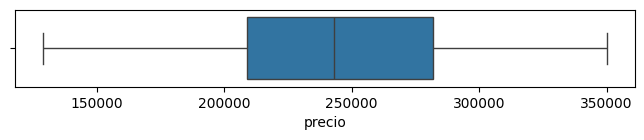

In [ ]:
# comprobamos outliers
fig, ax = plt.subplots(figsize=(8, 1))
sns.boxplot(data=df_entrenar, x='precio')
plt.show()

No apreciamos outlier en el precio.

## gestión de los nulos

In [ ]:
df_entrenar.isnull().sum()

,0
id_vivienda,0
superficie,10
num_hab,0
distancia,0
fecha_const,0
parking,0
precio,0


Eliminamos los 10 nulos

In [ ]:
df_entrenar = df_entrenar.dropna()

In [ ]:
df_predecir.isnull().sum()

,0
id_vivienda,0
superficie,0
num_hab,0
distancia,0
fecha_const,0
parking,0


## gestión de las variables categóricas

### parking

In [ ]:
df_entrenar['parking'].unique()

array(['ext', 'sin', 'int'], dtype=object)

In [ ]:
df_entrenar['parking'].value_counts()

,count
parking,
ext,1742
int,1668
sin,1580


trataremos la variable parking con one hot encoding, creando una columna booleana por cada una de la categorias

### fecha_const

vamos a cambiar la fecha de contrucción por el año de construcción

In [ ]:
df_entrenar['fecha_const'] = pd.to_datetime(df_entrenar['fecha_const'])
df_entrenar['fecha_const'] = df_entrenar['fecha_const'].dt.year

df_predecir['fecha_const'] = pd.to_datetime(df_predecir['fecha_const'])
df_predecir['fecha_const'] = df_predecir['fecha_const'].dt.year

In [ ]:
df_entrenar

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,precio
0,viv_1,65.0,1,7,1991,ext,166000
1,viv_2,97.0,4,8,1994,ext,279000
2,viv_3,80.0,4,4,1970,sin,233000
3,viv_4,73.0,1,1,1983,ext,182000
4,viv_5,86.0,2,8,1999,sin,210000
...,...,...,...,...,...,...,...
6987,viv_6988,130.0,3,7,1996,sin,286000
6988,viv_6989,120.0,3,8,2022,ext,299000
6989,viv_6990,76.0,4,7,2006,ext,245000
6992,viv_6993,128.0,3,8,2022,sin,276000


### id_vivienda

eliminamos el id_vivienda por ser único y no aportar para generalizar una regla para definir el precio de la vivienda: el precio no depende del id de la vivienda.

In [ ]:
df_entrenar.drop(['id_vivienda'], inplace=True, axis=1)

para el dataset a predecir, conservamos el id de las viviendas en una lista para entregar posteriormente un archivo con el id de la vivienda y su precio predicho.  
ojo: a partir de este momento no podemos quitar observaciones ni cambiar el orden de las viviendas del dataset a predecir

In [ ]:
id_viviendas_predecir = df_predecir['id_vivienda']
df_predecir.drop(['id_vivienda'], inplace=True, axis=1)

### one hot encoding

In [ ]:
df_entrenar = pd.get_dummies(df_entrenar)
df_predecir = pd.get_dummies(df_predecir)

In [ ]:
df_entrenar

,superficie,num_hab,distancia,fecha_const,precio,parking_ext,parking_int,parking_sin
0,65.0,1,7,1991,166000,True,False,False
1,97.0,4,8,1994,279000,True,False,False
2,80.0,4,4,1970,233000,False,False,True
3,73.0,1,1,1983,182000,True,False,False
4,86.0,2,8,1999,210000,False,False,True
...,...,...,...,...,...,...,...,...
6987,130.0,3,7,1996,286000,False,False,True
6988,120.0,3,8,2022,299000,True,False,False
6989,76.0,4,7,2006,245000,True,False,False
6992,128.0,3,8,2022,276000,False,False,True


In [ ]:
df_entrenar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4990 entries, 0 to 6994
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   superficie   4990 non-null   float64
 1   num_hab      4990 non-null   int64  
 2   distancia    4990 non-null   int64  
 3   fecha_const  4990 non-null   int32  
 4   precio       4990 non-null   int64  
 5   parking_ext  4990 non-null   bool   
 6   parking_int  4990 non-null   bool   
 7   parking_sin  4990 non-null   bool   
dtypes: bool(3), float64(1), int32(1), int64(3)
memory usage: 229.0 KB


In [ ]:
df_predecir

,superficie,num_hab,distancia,fecha_const,parking_ext,parking_int,parking_sin
6,110.0,4,1,1978,True,False,False
7,126.0,1,1,1997,True,False,False
14,82.0,3,5,1965,True,False,False
20,104.0,2,3,2001,True,False,False
25,62.0,1,2,1995,False,False,True
...,...,...,...,...,...,...,...
6995,98.0,2,2,2006,False,True,False
6996,111.0,4,2,1981,True,False,False
6997,76.0,3,4,2009,True,False,False
6998,128.0,3,5,1979,False,False,True


## alta correlación

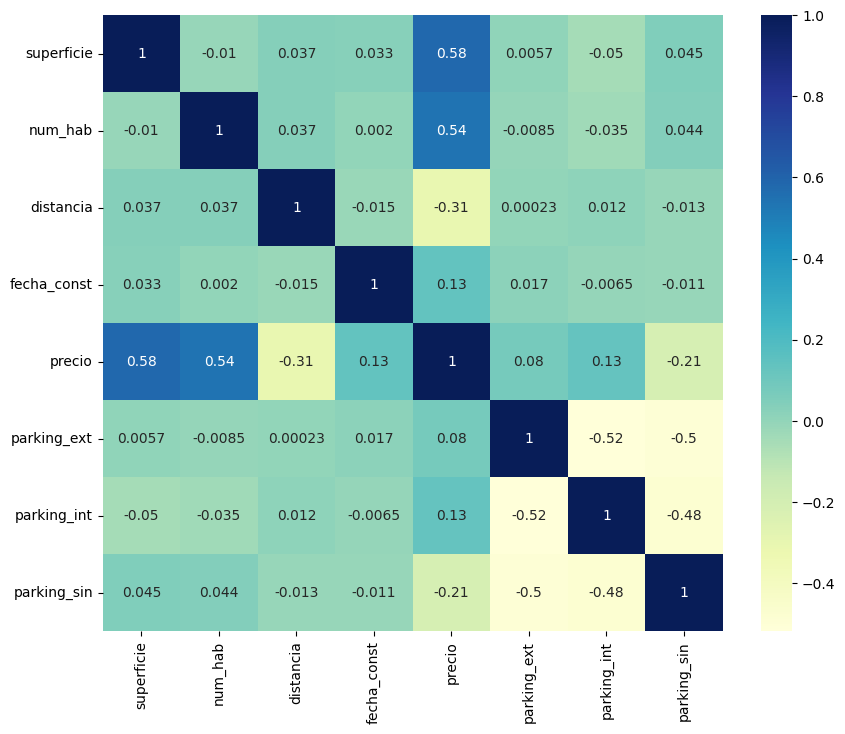

In [ ]:
df_corr = df_entrenar.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=df_corr, annot=True, cmap='YlGnBu')
plt.show()

## baja varianza

Una variable con poca varianza aporta muy poco valor al modelo para que pueda genaralizar.  
Conviene quitarlas, para ganar tiempo computacional.

In [ ]:
var_poca_varianza = []

for col in df_entrenar.columns:
  print(col)
  print(df_entrenar[col].var())
  if df_entrenar[col].var() < 0.01:
    print('baja varianza')
    var_poca_varianza.append(col)
  print(20*'-')
print('eliminar', var_poca_varianza)

superficie
401.79388598805383
--------------------
num_hab
1.1573569668903347
--------------------
distancia
7.766615853474973
--------------------
fecha_const
294.700282264269
--------------------
precio
2257539856.1805935
--------------------
parking_ext
0.22727419159826973
--------------------
parking_int
0.22257768694333951
--------------------
parking_sin
0.21642001180151443
--------------------
eliminar []


# Modelado

## feature importance

Creamos un árbol de decisión básico para averiguar las variables más utilizadas en el modelo.

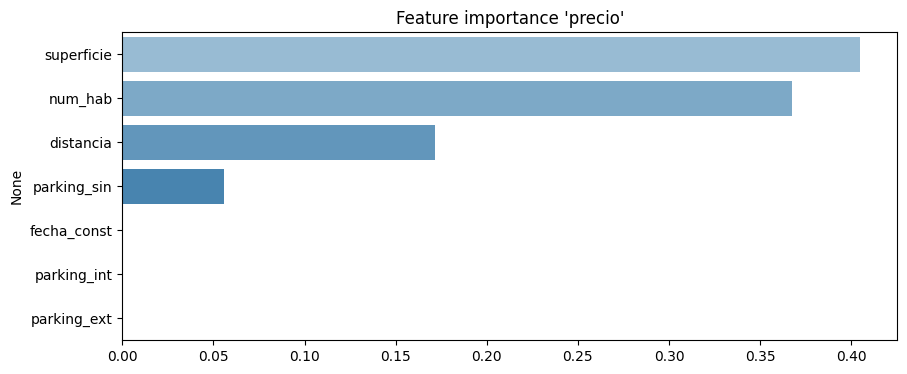

In [ ]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df_entrenar.drop(target,axis=1), df_entrenar[target]
# entrena un RandomForest Classifier
clf = RandomForestRegressor(**params)
clf = clf.fit(x, y)
# Plotea las 10 mejores Features importances
features = clf.feature_importances_[:10]
columnas = x.columns[:10]
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.title("Feature importance '{}'".format(target))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## split train-test

Separamos el dataset de entrenamiento en 2: 70% para entrenar y 30% para evaluar.

In [ ]:
# se guarda la target como 'y' y las features como 'X'
y = df_entrenar[target]
X = df_entrenar.drop(target, axis=1)

# se utilizan 70% de los datos para entrenar el modelo y se guardan 30% de los datos para evaluar el modelo (de forma aleatoria)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train

,superficie,num_hab,distancia,fecha_const,parking_ext,parking_int,parking_sin
4103,78.0,1,8,1980,False,False,True
1964,124.0,3,7,1968,False,False,True
3175,89.0,1,9,2006,True,False,False
1132,64.0,1,4,2023,True,False,False
1795,97.0,1,10,2008,False,False,True
...,...,...,...,...,...,...,...
6184,84.0,4,1,2012,True,False,False
640,105.0,2,8,2020,False,True,False
4327,99.0,2,8,1984,False,True,False
5279,80.0,4,3,1993,False,True,False


In [ ]:
X_test

,superficie,num_hab,distancia,fecha_const,parking_ext,parking_int,parking_sin
6608,70.0,1,2,2008,False,False,True
3223,81.0,1,7,1985,False,False,True
5140,109.0,2,7,1994,False,True,False
1689,96.0,4,7,1996,False,False,True
4241,69.0,3,9,1996,False,True,False
...,...,...,...,...,...,...,...
2536,127.0,2,8,2007,False,False,True
1928,130.0,2,10,1974,True,False,False
3428,98.0,3,8,1995,False,False,True
4193,79.0,2,9,1987,False,True,False


In [ ]:
y_train

,precio
4103,165000
1964,268000
3175,181000
1132,168000
1795,153000
...,...
6184,281000
640,261000
4327,252000
5279,276000


In [ ]:
y_test

,precio
6608,168000
3223,173000
5140,277000
1689,258000
4241,209000
...,...
2536,252000
1928,215000
3428,239000
4193,212000


## estandarización

Con un algoritmo de árbol de decisión, no es necesario estandarizar. No influye en el resultado.  
Con un algoritmo lineal, es absolutamente imprescindible.  
Como no sabemos qué tipo de algoritmo ganará la competición, estandarizamos.

In [ ]:
# se estandarizan las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train, con la media de X_train

# se estandarizan las variables del dataset a predecir según la regla definida con el X_train
X_predecir = scaler.transform(df_predecir)

## competición de modelos

In [ ]:
# añadimos en una lista los modelos que queremos poner a competir

modelos = []
modelos.append(('LinearRegression', LinearRegression()))
modelos.append(('Ridge', Ridge(random_state=42)))
modelos.append(('Lasso', Lasso(random_state=42)))
modelos.append(('ElasticNet', ElasticNet(random_state=42)))
modelos.append(('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42)))
modelos.append(('CatBoostRegressor', CatBoostRegressor(verbose=False, random_state=42)))
modelos.append(('XGBRegressor', XGBRegressor(random_state=42)))

utilizaremos la métrica RMSE para evaluar el modelo

In [ ]:
metricas_modelos = pd.DataFrame(columns=['modelo', 'RMSE'])

for nombre, modelo in modelos:

    # entrenamos el modelo
    modelo.fit(X_train, y_train)

    # hacemos la predicción sobre el dataset de test
    y_pred = modelo.predict(X_test)

    # calculamos el AUC
    rmse = metrics.root_mean_squared_error(y_test, y_pred)

    # imprimimos el resultado por modelo
    metricas_modelos = pd.concat([metricas_modelos,
                                  pd.DataFrame({'modelo': nombre, 'RMSE': rmse}, index=[0])
                                  ])
    print(modelo, rmse)

metricas_modelos.sort_values('RMSE', ascending=True)

LinearRegression() 18293.286012589208
Ridge(random_state=42) 18293.37494389189
Lasso(random_state=42) 18293.3353629471
ElasticNet(random_state=42) 23938.038007671683
GradientBoostingRegressor(random_state=42) 3745.413923128642
<catboost.core.CatBoostRegressor object at 0x7ddc6d08f220> 2158.0174487222707
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
         

,modelo,RMSE
0,CatBoostRegressor,2158.017449
0,XGBRegressor,3148.803475
0,GradientBoostingRegressor,3745.413923
0,LinearRegression,18293.286013
0,Lasso,18293.335363
0,Ridge,18293.374944
0,ElasticNet,23938.038008


## hiperparametrizar el modelo ganador

In [ ]:
# gridsearch
parameters = {'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.3],
              'n_estimators': [100, 300, 500, 800, 1000],
              'max_depth': [3, 4, 5, 6, 7, 8],
              'max_leaves': [0, 1, 2, 3],
              'eval_metric': ['rmse'],
              'verbosity': [0]}

In [ ]:
modelo =  LinearRegression()

In [ ]:
# # se prueban todas las combinaciones de parametros
# # al tardar tanto, comento el código
# modelo_grid = GridSearchCV(modelo,
#                            parameters,
#                            cv=2,
#                            verbose=True)

# modelo_grid.fit(X_train, y_train)

# # se imprime el modelo con los mejores parametros
# print('mejores parametros:')
# modelo_grid.best_params_

## entrenamiento del modelo final

In [ ]:
# selección del mejor modelo con los mejores parámetros
# modelo =  CatBoostRegressor(eval_metric='rmse', learning_rate=0.1, max_depth=8, max_leaves=0, n_estimators=800, verbosity=0)
# modelo =  CatBoostRegressor(verbose=False)
modelo =  LinearRegression()

# entrenamiento
modelo.fit(X_train, y_train)

LinearRegression()

# Evaluación

In [ ]:
# evaluación en el dataset de train
y_pred_train = modelo.predict(X_train)

# evaluación de la métrica
rmse_train = metrics.root_mean_squared_error(y_train, y_pred_train)
rmse_train

18693.165095639033

In [ ]:
# evaluación en el dataset de test
y_pred_test = modelo.predict(X_test)

# evaluación de la métrica
rmse_test = metrics.root_mean_squared_error(y_test, y_pred_test)
rmse_test

18293.286012589208

La diferencia entre la métrica sobre el dataset de train y la métrica sobre el dataset de test es el **OVERFITTING**.  
Tener en cuenta que los datos del dataset no son reales, es normal que el modelo aprenda tan bien sobre los datos de train.

# Predicción

## predict

In [ ]:
# hacemos la predicción sobre el dataset a predecir
predicciones = modelo.predict(X_predecir)

In [ ]:
predicciones

array([327130.40703988, 279827.68734611, 233298.1316407 , ...,
       243637.08661716, 279857.04178404, 248444.46314249])

In [ ]:
df_predicciones = pd.DataFrame()

In [ ]:
df_predicciones['id_vivienda'] = id_viviendas_predecir
df_predicciones['pred_precio'] = predicciones
df_predicciones['pred_precio'] = np.round(df_predicciones['pred_precio'], 0)
df_predicciones['pred_precio'] = df_predicciones['pred_precio'].astype('int64')

df_predicciones

,id_vivienda,pred_precio
6,viv_7,327130
7,viv_8,279828
14,viv_15,233298
20,viv_21,262454
25,viv_26,156659
...,...,...
6995,viv_6996,267867
6996,viv_6997,323409
6997,viv_6998,243637
6998,viv_6999,279857


**Entregamos el dataset con la predicción de cuales son las viviendas que se venderán, ordenado de mayor a menor.**